# Explore here

In [ ]:
# Standard library imports
from pathlib import Path

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.preprocessing import OrdinalEncoder, PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.exceptions import ConvergenceWarning

# Local imports
from pathlib import Path
print("CWD:", Path.cwd())
print("Found:", list(Path(".").rglob("helper_functions.py")))

# Set display options for pandas
pd.set_option('display.max_rows', 100)

In [ ]:
# Load and save the data

data_url = 'https://raw.githubusercontent.com/4GeeksAcademy/regularized-linear-regression-project-tutorial/main/demographic_health_data.csv'
data_df = pd.read_csv(data_url, sep=',')

Path('../data/raw').mkdir(parents=True, exist_ok=True)

In [ ]:
# Inspect

data_df.head().transpose()
data_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Data columns (total 108 columns):
 #    Column                                                                         Non-Null Count  Dtype  
---   ------                                                                         --------------  -----  
 0    fips                                                                           3140 non-null   int64  
 1    TOT_POP                                                                        3140 non-null   int64  
 2    0-9                                                                            3140 non-null   int64  
 3    0-9 y/o % of total pop                                                         3140 non-null   float64
 4    19-Oct                                                                         3140 non-null   int64  
 5    10-19 y/o % of total pop                                                       3140 non-null   float64
 6    20-29         

In [ ]:
# Initial Feature Selection
# Our label is the rate of any condition per 100 people
label = data_df['anycondition_number'] / (data_df['TOT_POP'] / 100)

In [ ]:
# Age Features
# Select age-related features
age_features = data_df.columns[2:20]
age_df = data_df[age_features].copy()

# Remove age count features, keeping only percentages
feature_drops = age_df.filter(regex = '^\d+-\d+$').columns
age_df.drop(columns=feature_drops, inplace=True)
age_df.drop(columns=['19-Oct', '80+'], inplace=True)

age_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   0-9 y/o % of total pop    3140 non-null   float64
 1   10-19 y/o % of total pop  3140 non-null   float64
 2   20-29 y/o % of total pop  3140 non-null   float64
 3   30-39 y/o % of total pop  3140 non-null   float64
 4   40-49 y/o % of total pop  3140 non-null   float64
 5   50-59 y/o % of total pop  3140 non-null   float64
 6   60-69 y/o % of total pop  3140 non-null   float64
 7   70-79 y/o % of total pop  3140 non-null   float64
 8   80+ y/o % of total pop    3140 non-null   float64
dtypes: float64(9)
memory usage: 220.9 KB


In [ ]:
# Ethnicity Features
# Select Ethnicity-related features
ethnicity_features = data_df.columns[20:32]
ethnicity_df = data_df[ethnicity_features].copy()

# Remove count features, keeping only percentages
features = ethnicity_df.filter(regex = '^\%').columns
ethnicity_df = ethnicity_df[features]

ethnicity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   % White-alone        3140 non-null   float64
 1   % Black-alone        3140 non-null   float64
 2   % NA/AI-alone        3140 non-null   float64
 3   % Asian-alone        3140 non-null   float64
 4   % Hawaiian/PI-alone  3140 non-null   float64
 5   % Two or more races  3140 non-null   float64
dtypes: float64(6)
memory usage: 147.3 KB


In [ ]:
# Population Features
population_features = ['TOT_POP', 'POP_ESTIMATE_2018', 'N_POP_CHG_2018', 'R_birth_2018', 'R_death_2018']
population_df = data_df[population_features].copy()
population_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   TOT_POP            3140 non-null   int64  
 1   POP_ESTIMATE_2018  3140 non-null   int64  
 2   N_POP_CHG_2018     3140 non-null   int64  
 3   R_birth_2018       3140 non-null   float64
 4   R_death_2018       3140 non-null   float64
dtypes: float64(2), int64(3)
memory usage: 122.8 KB


In [ ]:
# Educationb Features
education_features = data_df.columns[45:49]
education_df = data_df[education_features].copy()
education_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Data columns (total 4 columns):
 #   Column                                                                   Non-Null Count  Dtype  
---  ------                                                                   --------------  -----  
 0   Percent of adults with less than a high school diploma 2014-18           3140 non-null   float64
 1   Percent of adults with a high school diploma only 2014-18                3140 non-null   float64
 2   Percent of adults completing some college or associate's degree 2014-18  3140 non-null   float64
 3   Percent of adults with a bachelor's degree or higher 2014-18             3140 non-null   float64
dtypes: float64(4)
memory usage: 98.3 KB


In [ ]:
# Employment Features
employment_features = data_df.columns[56:62]
employment_df = data_df[employment_features].copy()
employment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Data columns (total 6 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Civilian_labor_force_2018                  3140 non-null   int64  
 1   Employed_2018                              3140 non-null   int64  
 2   Unemployed_2018                            3140 non-null   int64  
 3   Unemployment_rate_2018                     3140 non-null   float64
 4   Median_Household_Income_2018               3140 non-null   int64  
 5   Med_HH_Income_Percent_of_State_Total_2018  3140 non-null   float64
dtypes: float64(2), int64(4)
memory usage: 147.3 KB


In [ ]:
# Healthcare Access Features
healthcare_features = data_df.columns[62:75]
healthcare_df = data_df[healthcare_features].copy()
healthcare_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Data columns (total 13 columns):
 #   Column                                                                         Non-Null Count  Dtype  
---  ------                                                                         --------------  -----  
 0   Active Physicians per 100000 Population 2018 (AAMC)                            3140 non-null   float64
 1   Total Active Patient Care Physicians per 100000 Population 2018 (AAMC)         3140 non-null   float64
 2   Active Primary Care Physicians per 100000 Population 2018 (AAMC)               3140 non-null   float64
 3   Active Patient Care Primary Care Physicians per 100000 Population 2018 (AAMC)  3140 non-null   float64
 4   Active General Surgeons per 100000 Population 2018 (AAMC)                      3140 non-null   float64
 5   Active Patient Care General Surgeons per 100000 Population 2018 (AAMC)         3140 non-null   float64
 6   Total nurse practitioner

In [ ]:
# Other Features
other_features = data_df.columns[78:82]
other_df = data_df[other_features].copy()
other_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   COUNTY_NAME  3140 non-null   object
 1   STATE_NAME   3140 non-null   object
 2   STATE_FIPS   3140 non-null   int64 
 3   CNTY_FIPS    3140 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 98.3+ KB


In [ ]:
# Recombine Selected Features
data_df = pd.concat([age_df,ethnicity_df,population_df,education_df,employment_df,healthcare_df,other_df], axis=1)
data_df['morbidity'] = label

# Rename features with shorter, more plot-friendly names
column_renames = {
    # Age features (percentages)
 
    '0-9 y/o % of total pop': 'pct_0-9',
    '10-19 y/o % of total pop': 'pct_10-19',
    '20-29 y/o % of total pop': 'pct_20-29',
    '30-39 y/o % of total pop': 'pct_30-39',
    '40-49 y/o % of total pop': 'pct_40-49',
    '50-59 y/o % of total pop': 'pct_50-59',
    '60-69 y/o % of total pop': 'pct_60-69',
    '70-79 y/o % of total pop': 'pct_70-79',
    '80+ y/o % of total pop': 'pct_80+',
    
    # Ethnicity features
    '% Not Hispanic or Latino': 'pct_non_hispanic',
    '% Hispanic or Latino': 'pct_hispanic',
    '% American Indian and Alaska Native Alone': 'pct_native_american',
    '% Asian Alone': 'pct_asian',
    '% Black or African American Alone': 'pct_black',
    '% Native Hawaiian and Other Pacific Islander Alone': 'pct_pacific_islander',
    '% Two or More Races': 'pct_multiracial',
    '% White Alone': 'pct_white',
    
    # Population features
    'TOT_POP': 'total_population',
    'POP_ESTIMATE_2018': 'pop_estimate_2018',
    'N_POP_CHG_2018': 'pop_change_2018',
    'R_birth_2018': 'birth_rate_2018',
    'R_death_2018': 'death_rate_2018',
    
    # Education features
    'Percent of adults with less than a high school diploma 2014-18': 'pct_no_hs_diploma',
    'Percent of adults with a high school diploma only 2014-18': 'pct_hs_only',
    'Percent of adults completing some college or associate\'s degree 2014-18': 'pct_some_college',
    'Percent of adults with a bachelor\'s degree or higher 2014-18': 'pct_bachelor_plus',
    
    # Employment features
    'Civilian_labor_force_2018': 'civilian_labor_force',
    'Employed_2018': 'employed_2018',
    'Unemployed_2018': 'unemployed_2018',
    'Unemployment_rate_2018': 'unemployment_rate',
    'Median_Household_Income_2018': 'median_household_income',
    'Med_HH_Income_Percent_of_State_Total_2018': 'income_pct_of_state',
    
    # Healthcare access features
    'Active Physicians per 100000 Population 2018 (AAMC)': 'active_physicians_per_100k',
    'Active Patient Care Primary Care Physicians per 100000 Population 2018 (AAMC)': 'primary_physicians_per_100k',
    'Active Primary Care Physicians per 100000 Population 2018 (AAMC)': 'active_primary_care_per_100k',
    'Active General Surgeons per 100000 Population 2018 (AAMC)': 'general_surgeons_per_100k',
    'Active Patient Care General Surgeons per 100000 Population 2018 (AAMC)': 'surgeons_per_100k',
    'Total Active Patient Care Physicians per 100000 Population 2018 (AAMC)': 'total_physicians_per_100k',
    'Total nurse practitioners (2019)': 'total_nurse_practitioners',
    'Total physician assistants (2019)': 'total_physician_assistants',
    'Total Hospitals (2019)': 'total_hospitals',
    'Internal Medicine Primary Care (2019)': 'internal_medicine_physicians',
    'Family Medicine/General Practice Primary Care (2019)': 'family_medicine_physicians',
    'Total Specialist Physicians (2019)': 'total_specialist_physicians',
}

data_df.rename(columns=column_renames, inplace=True)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Data columns (total 48 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   pct_0-9                       3140 non-null   float64
 1   pct_10-19                     3140 non-null   float64
 2   pct_20-29                     3140 non-null   float64
 3   pct_30-39                     3140 non-null   float64
 4   pct_40-49                     3140 non-null   float64
 5   pct_50-59                     3140 non-null   float64
 6   pct_60-69                     3140 non-null   float64
 7   pct_70-79                     3140 non-null   float64
 8   pct_80+                       3140 non-null   float64
 9   % White-alone                 3140 non-null   float64
 10  % Black-alone                 3140 non-null   float64
 11  % NA/AI-alone                 3140 non-null   float64
 12  % Asian-alone                 3140 non-null   float64
 13  % H

In [ ]:
#EDA: Data Composition: Catagorical Variables:

cat_features = data_df.select_dtypes(include=['object', 'category']).columns.tolist()
for col in cat_features:
    print(f"{col}:\n{data_df[col].value_counts(dropna=False)}\n")


COUNTY_NAME:
COUNTY_NAME
Washington         31
Jefferson          26
Jackson            24
Franklin           24
Lincoln            24
                   ..
Waldo               1
Sagadahoc           1
Piscataquis         1
Penobscot           1
Prince George's     1
Name: count, Length: 1841, dtype: int64

STATE_NAME:
STATE_NAME
Texas                   254
Georgia                 159
Virginia                133
Kentucky                120
Missouri                115
Kansas                  105
Illinois                102
North Carolina          100
Iowa                     99
Tennessee                95
Nebraska                 93
Indiana                  92
Ohio                     88
Minnesota                87
Michigan                 83
Mississippi              82
Oklahoma                 77
Arkansas                 75
Wisconsin                72
Pennsylvania             67
Alabama                  67
Florida                  67
South Dakota             66
Louisiana                

morbidity                       1.000000
death_rate_2018                 0.627166
pct_hs_only                     0.621180
pct_no_hs_diploma               0.514710
pct_70-79                       0.403930
unemployment_rate               0.400635
% Black-alone                   0.310568
pct_60-69                       0.298933
pct_80+                         0.264164
pct_50-59                       0.253994
CNTY_FIPS                       0.084444
STATE_FIPS                      0.030234
% Hawaiian/PI-alone            -0.032310
pct_40-49                      -0.035110
surgeons_per_100k              -0.042762
% NA/AI-alone                  -0.042989
general_surgeons_per_100k      -0.049203
% White-alone                  -0.158532
% Two or more races            -0.201325
pct_some_college               -0.210650
pct_20-29                      -0.214774
birth_rate_2018                -0.226046
ICU Beds_x                     -0.228671
unemployed_2018                -0.233152
pop_change_2018 

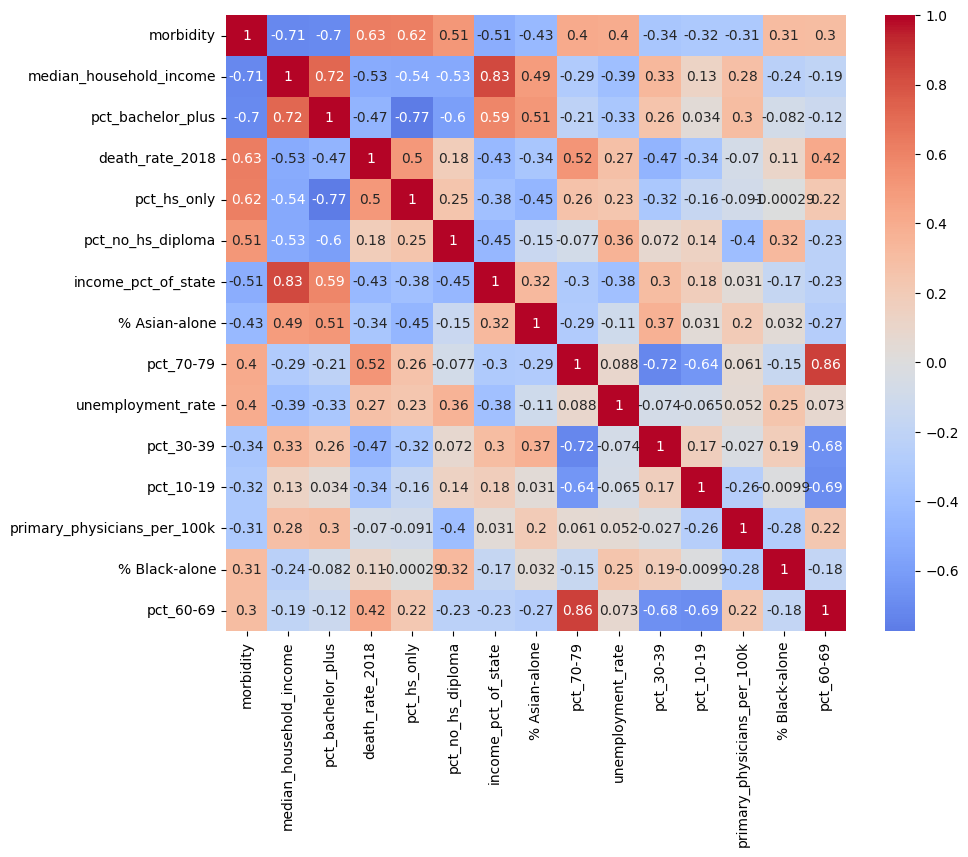

In [ ]:
# Quick summary
data_df.describe().T

# Correlation with label
corrs = data_df.corr(numeric_only=True)['morbidity'].sort_values(ascending=False)
print(corrs)

# Heatmap of top correlations
top_corrs = corrs.abs().sort_values(ascending=False).head(15).index
plt.figure(figsize=(10, 8))
sns.heatmap(data_df[top_corrs].corr(), annot=True, cmap='coolwarm', center=0)
plt.show()


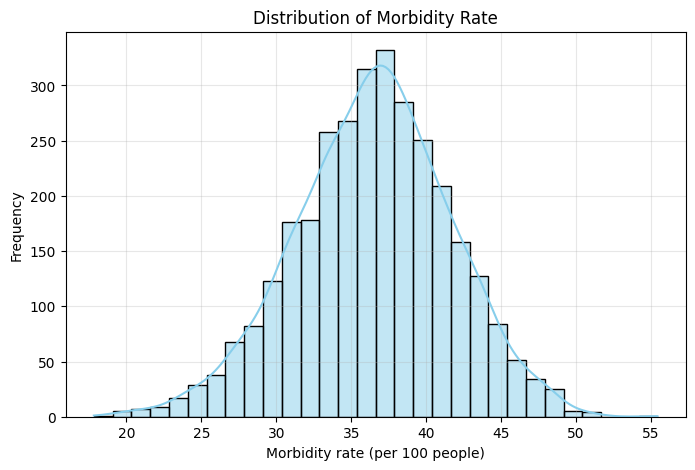

In [ ]:
# Dist. of Label

import matplotlib.pyplot as plt
import seaborn as sns

# Plot histogram of the label
plt.figure(figsize=(8, 5))
sns.histplot(label, bins=30, kde=True, color='skyblue', edgecolor='black')
plt.xlabel('Morbidity rate (per 100 people)')
plt.ylabel('Frequency')
plt.title('Distribution of Morbidity Rate')
plt.grid(alpha=0.3)
plt.show()


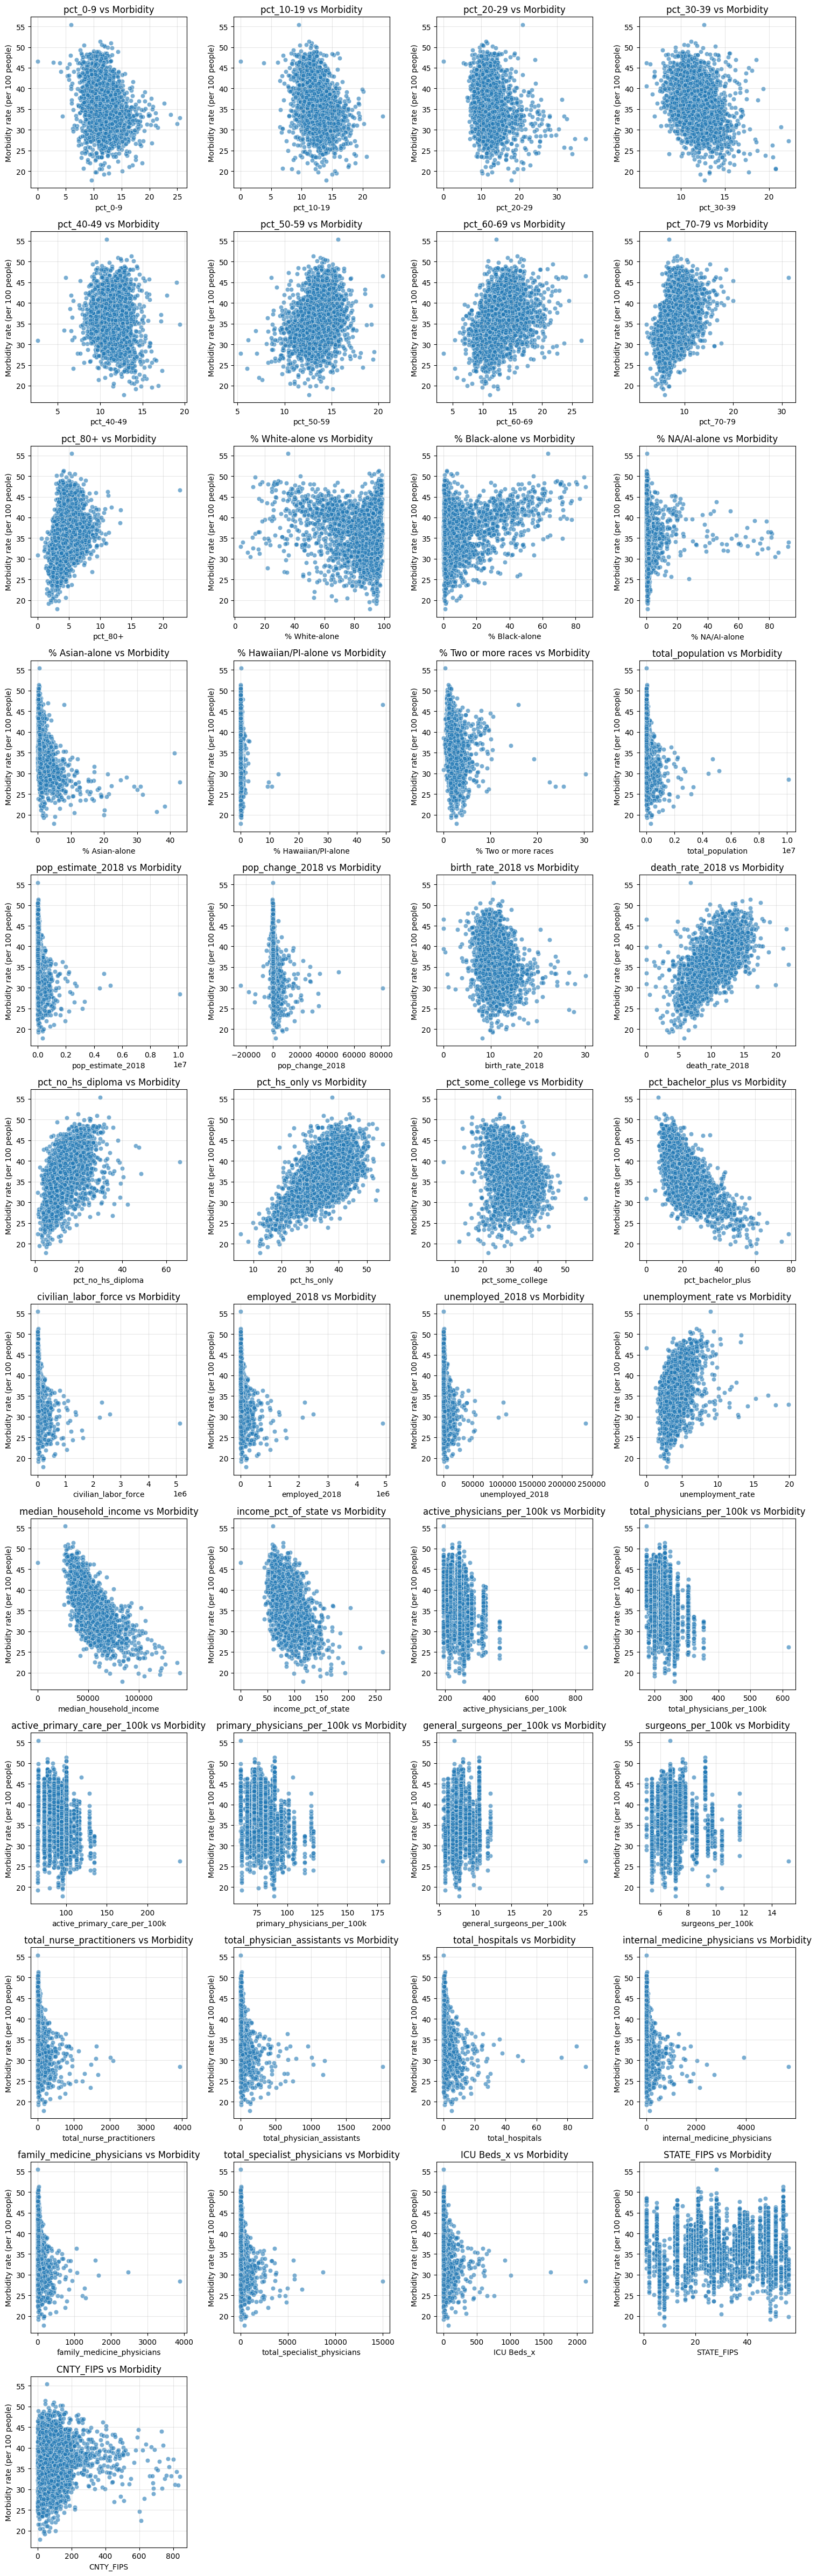

In [ ]:
# Feature-label correlations

# Select numerical features (excluding the label)
num_features = data_df.select_dtypes(include=[np.number]).columns.drop('morbidity')

# Set number of plots per row
cols = 4
rows = int(np.ceil(len(num_features) / cols))

fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))
axes = axes.flatten()  # Flatten so we can index easily

# Loop through and plot
for i, feature in enumerate(num_features):
    sns.scatterplot(
        x=data_df[feature],
        y=data_df['morbidity'],
        alpha=0.6,
        ax=axes[i]
    )
    axes[i].set_title(f"{feature} vs Morbidity")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Morbidity rate (per 100 people)")
    axes[i].grid(alpha=0.3)

# Remove empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



In [ ]:
# 1) See which frame you’re actually using
print("df columns:", list(data_df.columns)[:8], "…")
print("data_df columns:", list(data_df.columns)[:8], "…")

# 2) If morbidity is missing, (re)create it on the frame you’ll use
target_frame = data_df  # or df, pick ONE and stick with it
if 'morbidity' not in target_frame.columns:
    target_frame = target_frame.copy()
    target_frame['morbidity'] = (
        target_frame['anycondition_number'] / (target_frame['TOT_POP'] / 100)
    )

# 3) (Optional) sanity check for typos/whitespace/case
print([c for c in target_frame.columns if 'morb' in c.lower()])

# 4) Do the split using the SAME frame
X = target_frame.drop(columns=['morbidity'])
y = target_frame['morbidity']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")


df columns: ['pct_0-9', 'pct_10-19', 'pct_20-29', 'pct_30-39', 'pct_40-49', 'pct_50-59', 'pct_60-69', 'pct_70-79'] …
data_df columns: ['pct_0-9', 'pct_10-19', 'pct_20-29', 'pct_30-39', 'pct_40-49', 'pct_50-59', 'pct_60-69', 'pct_70-79'] …
['morbidity']
Training set size: (2512, 47)
Testing set size: (628, 47)


In [ ]:
# Feature Encoding
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Ensure 'morbidity' exists
if 'morbidity' not in data_df.columns:
    raise ValueError("The label column 'morbidity' is missing from the DataFrame.")

# Identify categorical and numerical columns
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X_train.select_dtypes(exclude=['object', 'category']).columns.tolist()

# Create a ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols),
        ('num', 'passthrough', num_cols)
    ]
)

# Fit the encoder on training data, transform both train and test sets
X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

print(f"Encoded training set shape: {X_train_encoded.shape}")
print(f"Encoded testing set shape: {X_test_encoded.shape}")


Encoded training set shape: (2512, 1629)
Encoded testing set shape: (628, 1629)


/home/vscode/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
# Interaction features
poly_transformer = PolynomialFeatures(degree=2, include_bias=False)
poly_transformer.fit(X_train.drop(columns=['morbidity']))
poly_training_features = poly_transformer.transform(X_train.drop(columns=['morbidity']))
poly_testing_features = poly_transformer.transform(X_train.drop(columns=['morbidity']))

poly_training_df = pd.DataFrame(poly_training_features, columns=poly_transformer.get_feature_names_out())
poly_testing_df = pd.DataFrame(poly_testing_features, columns=poly_transformer.get_feature_names_out())

poly_training_df['morbidity'] = X_train['morbidity'].values
poly_testing_df['morbidity'] = X_train['morbidity'].values

KeyError: "['morbidity'] not found in axis"

In [ ]:
# Linear Model Training: Baseline

from sklearn.metrics import mean_squared_error, r2_score

# Calculate the training mean
baseline_pred_value = y_train.mean()

# Predict this constant for all test rows
y_pred_baseline = np.full_like(y_test, baseline_pred_value)

# Evaluate
rmse_baseline = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
r2_baseline = r2_score(y_test, y_pred_baseline)

print(f"Baseline prediction (mean morbidity): {baseline_pred_value:.2f}")
print(f"Baseline RMSE: {rmse_baseline:.4f}")
print(f"Baseline R²: {r2_baseline:.4f}")


Baseline prediction (mean morbidity): 36.42
Baseline RMSE: 5.1653
Baseline R²: -0.0011


In [ ]:
# Linear regression model

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train_encoded, y_train)

# Predict on test data
y_pred = lin_reg.predict(X_test_encoded)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression RMSE: {rmse:.4f}")
print(f"Linear Regression R²: {r2:.4f}")

Linear Regression RMSE: 2.3528
Linear Regression R²: 0.7923


/home/vscode/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


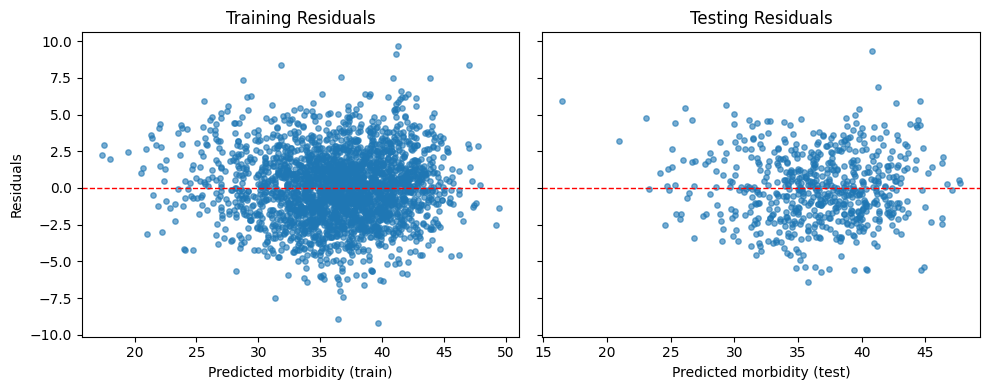

In [ ]:


from sklearn.pipeline import Pipeline

# Categorical columns (strings like "Oceana")
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Preprocess: one-hot encode categoricals, pass through numerics
preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols),
    ],
    remainder='passthrough'
)

# Model pipeline
model = Pipeline([
    ('prep', preprocess),
    ('reg', LinearRegression())
])

# Fit
model.fit(X_train, y_train)

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred  = model.predict(X_test)

# Residuals
train_resid = y_train - y_train_pred
test_resid  = y_test  - y_test_pred

# Residual plots
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

axs[0].scatter(y_train_pred, train_resid, alpha=0.6, s=15)
axs[0].axhline(0, color='red', linestyle='--', linewidth=1)
axs[0].set_title('Training Residuals')
axs[0].set_xlabel('Predicted morbidity (train)')
axs[0].set_ylabel('Residuals')

axs[1].scatter(y_test_pred, test_resid, alpha=0.6, s=15)
axs[1].axhline(0, color='red', linestyle='--', linewidth=1)
axs[1].set_title('Testing Residuals')
axs[1].set_xlabel('Predicted morbidity (test)')

plt.tight_layout()
plt.show()

/home/vscode/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


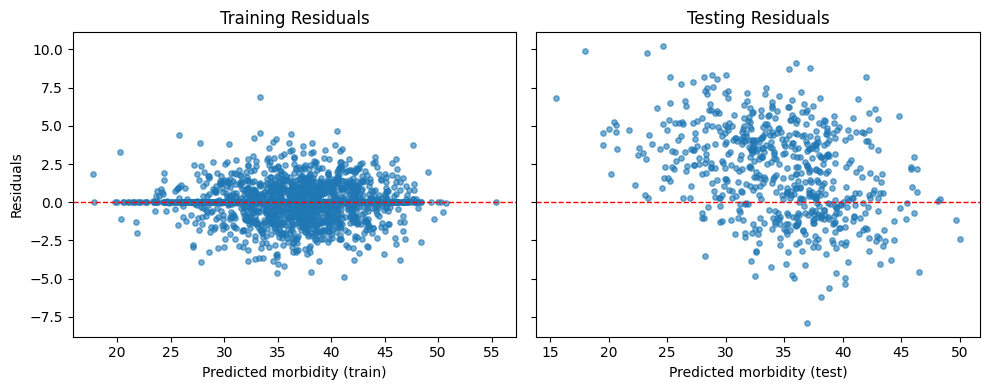

In [ ]:
# Model Regularization: Feature Scaling(This aids in model convergence during repeated training runs.)

from sklearn.pipeline import Pipeline 

# Separate column types
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X_train.select_dtypes(exclude=['object', 'category']).columns.tolist()

# Preprocessing: OneHot for categoricals, StandardScaler for numerics
preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols),
        ('num', StandardScaler(), num_cols)
    ],
    remainder='drop'
)

# Pipeline with scaling + regression
model = Pipeline([
    ('prep', preprocess),
    ('reg', LinearRegression())
])

# Fit model
model.fit(X_train, y_train)

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred  = model.predict(X_test)

# Residuals
train_resid = y_train - y_train_pred
test_resid  = y_test - y_test_pred

# Residual plots
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

axs[0].scatter(y_train_pred, train_resid, alpha=0.6, s=15)
axs[0].axhline(0, color='red', linestyle='--', linewidth=1)
axs[0].set_title('Training Residuals')
axs[0].set_xlabel('Predicted morbidity (train)')
axs[0].set_ylabel('Residuals')

axs[1].scatter(y_test_pred, test_resid, alpha=0.6, s=15)
axs[1].axhline(0, color='red', linestyle='--', linewidth=1)
axs[1].set_title('Testing Residuals')
axs[1].set_xlabel('Predicted morbidity (test)')

plt.tight_layout()
plt.show()


In [ ]:
# Lasso penalty optimization

import warnings
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.exceptions import ConvergenceWarning

# Preprocessing (same as before)
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X_train.select_dtypes(exclude=['object', 'category']).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols),
        ('num', StandardScaler(), num_cols),
    ],
    remainder='drop'
)

penalties = [0.000025, 0.00005, 0.0001, 0.0002, 0.0004, 0.0008, 0.0016, 0.0032, 0.0064, 0.0128, 0.0256]

rows = []
warnings.filterwarnings("ignore", category=ConvergenceWarning)

for alpha in penalties:
    model = Pipeline([
        ('prep', preprocess),
        ('reg', Lasso(alpha=alpha, max_iter=20000, tol=1e-4))
    ])
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    train_r2 = r2_score(y_train, y_train_pred)
    test_r2  = r2_score(y_test,  y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse  = np.sqrt(mean_squared_error(y_test,  y_test_pred))

    rows.append({
        "alpha": alpha,
        "Training R-squared": train_r2,
        "Testing R-Squared": test_r2,
        "Training RMSE": train_rmse,
        "Testing RMSE": test_rmse,
    })

    print(f"alpha={alpha:.6f} | R² train: {train_r2:.4f} | R² test: {test_r2:.4f} | RMSE test: {test_rmse:.4f}")

lasso_df = pd.DataFrame(rows)

# Sort and pick best
lasso_df_sorted = lasso_df.sort_values("Testing RMSE", ascending=True)
best_row = lasso_df_sorted.iloc[0]

print("\nBest by Test RMSE:")
print(best_row)


/home/vscode/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


alpha=0.000025 | R² train: 0.9575 | R² test: 0.8495 | RMSE test: 2.0024


/home/vscode/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


alpha=0.000050 | R² train: 0.9572 | R² test: 0.8530 | RMSE test: 1.9793


/home/vscode/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


alpha=0.000100 | R² train: 0.9562 | R² test: 0.8576 | RMSE test: 1.9480


/home/vscode/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


alpha=0.000200 | R² train: 0.9529 | R² test: 0.8637 | RMSE test: 1.9057


/home/vscode/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


alpha=0.000400 | R² train: 0.9429 | R² test: 0.8715 | RMSE test: 1.8507


/home/vscode/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


alpha=0.000800 | R² train: 0.9201 | R² test: 0.8794 | RMSE test: 1.7930


/home/vscode/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


alpha=0.001600 | R² train: 0.8936 | R² test: 0.8838 | RMSE test: 1.7600


/home/vscode/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


alpha=0.003200 | R² train: 0.8854 | R² test: 0.8835 | RMSE test: 1.7620


/home/vscode/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


alpha=0.006400 | R² train: 0.8805 | R² test: 0.8798 | RMSE test: 1.7901
alpha=0.012800 | R² train: 0.8703 | R² test: 0.8713 | RMSE test: 1.8521
alpha=0.025600 | R² train: 0.8473 | R² test: 0.8518 | RMSE test: 1.9870

Best by Test RMSE:
alpha                 0.001600
Training R-squared    0.893650
Testing R-Squared     0.883763
Training RMSE         1.687931
Testing RMSE          1.760016
Name: 6, dtype: float64


/home/vscode/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


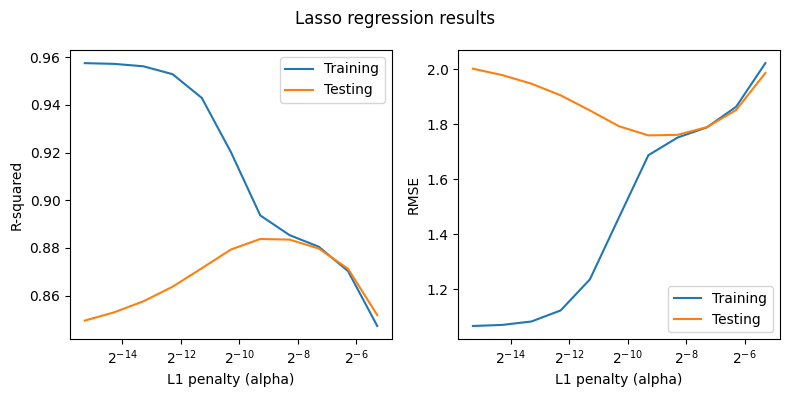

In [ ]:

plot_df = lasso_df.sort_values("alpha")

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle('Lasso regression results')

# R^2
axs[0].plot(plot_df["alpha"], plot_df["Training R-squared"], label='Training')
axs[0].plot(plot_df["alpha"], plot_df["Testing R-Squared"], label='Testing')
try:
    axs[0].set_xscale('log', base=2)
except TypeError:
    axs[0].set_xscale('log')  # fallback for older Matplotlib
axs[0].set_xlabel('L1 penalty (alpha)')
axs[0].set_ylabel('R-squared')
axs[0].legend(loc='best')

# RMSE
axs[1].plot(plot_df["alpha"], plot_df["Training RMSE"], label='Training')
axs[1].plot(plot_df["alpha"], plot_df["Testing RMSE"], label='Testing')
try:
    axs[1].set_xscale('log', base=2)
except TypeError:
    axs[1].set_xscale('log')
axs[1].set_xlabel('L1 penalty (alpha)')
axs[1].set_ylabel('RMSE')
axs[1].legend(loc='best')

plt.tight_layout()
plt.show()


/home/vscode/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/preprocessing/_enco

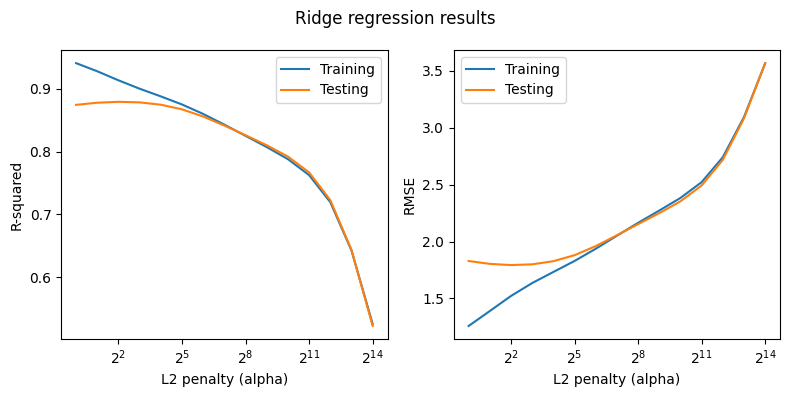

In [ ]:
# Ridge penalty optimization

# 1) Sweep alphas and collect metrics
penalties = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]

cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X_train.select_dtypes(exclude=['object', 'category']).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols),
        ('num', StandardScaler(), num_cols),
    ],
    remainder='drop'
)

rows = []
for alpha in penalties:
    model = Pipeline([
        ('prep', preprocess),
        ('reg', Ridge(alpha=alpha, random_state=42))
    ])
    model.fit(X_train, y_train)

    y_tr = model.predict(X_train)
    y_te = model.predict(X_test)

    rows.append({
        "alpha": alpha,
        "Training R-squared": r2_score(y_train, y_tr),
        "Testing R-Squared":  r2_score(y_test,  y_te),
        "Training RMSE": np.sqrt(mean_squared_error(y_train, y_tr)),
        "Testing RMSE":  np.sqrt(mean_squared_error(y_test,  y_te)),
    })

ridge_results = pd.DataFrame(rows).sort_values("alpha")

# 2) Plot
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle('Ridge regression results')

axs[0].plot(ridge_results["alpha"], ridge_results['Training R-squared'], label='Training')
axs[0].plot(ridge_results["alpha"], ridge_results['Testing R-Squared'], label='Testing')
try:
    axs[0].set_xscale('log', base=2)
except TypeError:
    axs[0].set_xscale('log')
axs[0].set_xlabel('L2 penalty (alpha)')
axs[0].set_ylabel('R-squared')
axs[0].legend(loc='best')

axs[1].plot(ridge_results["alpha"], ridge_results['Training RMSE'], label='Training')
axs[1].plot(ridge_results["alpha"], ridge_results['Testing RMSE'], label='Testing')
try:
    axs[1].set_xscale('log', base=2)
except TypeError:
    axs[1].set_xscale('log')
axs[1].set_xlabel('L2 penalty (alpha)')
axs[1].set_ylabel('RMSE')
axs[1].legend(loc='best')

plt.tight_layout()
plt.show()